In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization, Activation, Input
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, classification_report
from keras import regularizers
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings("ignore")

In [2]:
res = 216

def load_data(directory):
    images = []
    labels = []
    for folder in tqdm(os.listdir(directory)):
        label = folder
        data_path = os.path.join(directory, folder)
        if not os.path.isdir(data_path):
            continue
        for filename in tqdm(os.listdir(data_path), position=0, leave=True, desc=f"Loading images from {directory.split(os.sep)[-2]} folder"):
            img = cv2.imread(os.path.join(data_path, filename))
            if img is None:
                continue
            img = cv2.resize(img, (res, res))
            img = np.array(img)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)


In [4]:
x_train, y_train = load_data('chest_xray/chest_xray/train/')
x_test, y_test = load_data('chest_xray/chest_xray/test/')

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


In [5]:
y_train = np.where(y_train == 'NORMAL', 0, 1)
y_test = np.where(y_test == 'NORMAL', 0, 1)

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define the model structure
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(216, 216, 3), pooling='avg')
model = Sequential()
model.add(base_model)
model.add(Dense(1, activation='sigmoid'))  # For binary classification use 1 neuron with 'sigmoid' activation

# freeze the base model
base_model.trainable = False

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(x_train[:700], y_train[:700], validation_data=(x_test[:700], y_test[:700]), epochs=5)


Epoch 1/5
22/22 [==============================] - 100s 5s/step - loss: 0.9546 - accuracy: 0.7386 - val_loss: 5.4556 - val_accuracy: 0.6250
Epoch 2/5
22/22 [==============================] - 98s 5s/step - loss: 0.0053 - accuracy: 0.9971 - val_loss: 6.6467 - val_accuracy: 0.6250
Epoch 3/5
22/22 [==============================] - 98s 5s/step - loss: 0.0020 - accuracy: 0.9986 - val_loss: 6.8404 - val_accuracy: 0.6250
Epoch 4/5
22/22 [==============================] - 100s 5s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 6.8989 - val_accuracy: 0.6250
Epoch 5/5
22/22 [==============================] - 99s 5s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 6.9400 - val_accuracy: 0.6250


In [12]:
from sklearn.metrics import classification_report
import numpy as np

# make predictions on the test set
y_pred = model.predict(x_test)

# since this is a binary classification problem and our model uses a sigmoid function
# we will convert probabilities to class labels using a threshold of 0.5
y_pred = (y_pred > 0.5).astype(int)

# generate and print the classification report
report = classification_report(y_test, y_pred)
print(report)

20/20 [==============================] - 46s 2s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



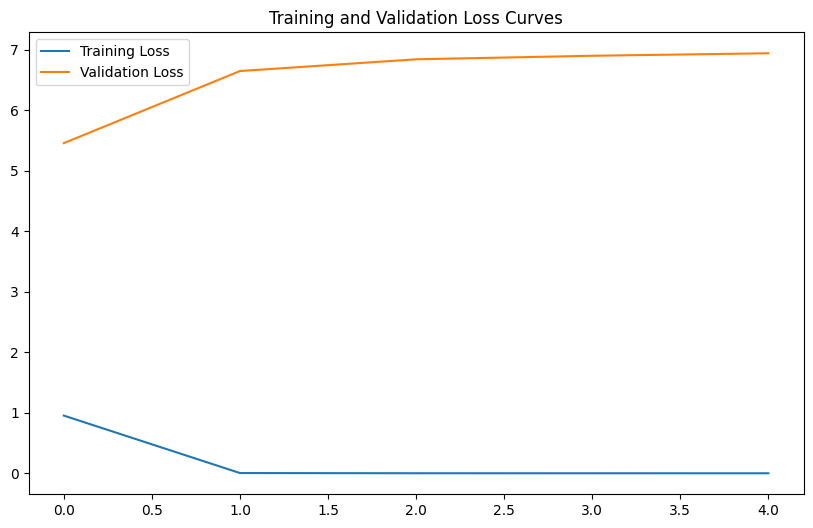

In [10]:
plt.figure(figsize=(10, 6))
plt.plot( history.history['loss'], label='Training Loss')
plt.plot( history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()